In [17]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import geoplot as gplt
import geoplot.crs as gcrs
from pyproj import CRS
import folium
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim

# 1. Importing the retail location data

In [3]:
retail_data = pd.read_csv("data/retail_locations.csv")

# drop duplicate rows if they exists

retail_data = retail_data.drop_duplicates()

# Obtain import the downloaded quebec building data into a geopandas dataframe

building_map = gpd.read_file('data/ODB_Quebec/odb_quebec.shp')


# Exploring the datasets

## a. Building Dataset

In [4]:
building_map

,OBJECTID,Longitude,Latitude,CSDUID,CSDNAME,Data_prov,Build_ID,Shape_Leng,Shape_Area,geometry
0,1,-73.520563,45.522783,2458227,Longueuil,Longueuil,24582270000001,301.838066,4277.811197,"POLYGON Z ((7634622.476 1247905.088 0.000, 763..."
1,2,-73.519587,45.517301,2458227,Longueuil,Longueuil,24582270000002,34.186237,72.432135,"POLYGON Z ((7634888.150 1247380.288 0.000, 763..."
2,3,-73.519608,45.519196,2458227,Longueuil,Longueuil,24582270000003,37.127362,69.981602,"POLYGON Z ((7634832.292 1247586.067 0.000, 763..."
3,4,-73.519585,45.521427,2458227,Longueuil,Longueuil,24582270000004,64.472888,215.574316,"POLYGON Z ((7634762.176 1247822.977 0.000, 763..."
4,5,-73.519033,45.518453,2458227,Longueuil,Longueuil,24582270000005,40.174462,99.038502,"POLYGON Z ((7634889.673 1247518.185 0.000, 763..."
...,...,...,...,...,...,...,...,...,...,...
452770,452771,-78.917494,48.168697,2486042,Rouyn-Noranda,Rouyn-Noranda,24860420032863,51.794678,158.393883,"POLYGON Z ((7159704.691 1434431.419 0.000, 715..."
452771,452772,-78.917280,48.205349,2486042,Rouyn-Noranda,Rouyn-Noranda,24860420032864,45.252540,137.854821,"POLYGON Z ((7158896.108 1438422.581 0.000, 715..."
452772,452773,-78.874204,48.361070,2486042,Rouyn-Noranda,Rouyn-Noranda,24860420032865,44.635499,113.727616,"POLYGON Z ((7158517.133 1456091.248 0.000, 715..."
452773,452774,-78.873966,48.361169,2486042,Rouyn-Noranda,Rouyn-Noranda,24860420032866,38.178762,90.998223,"POLYGON Z ((7158537.435 1456098.235 0.000, 715..."


In [5]:
# Check the data types of the bulding dataset
building_map.dtypes

OBJECTID         int64
Longitude      float64
Latitude       float64
CSDUID          object
CSDNAME         object
Data_prov       object
Build_ID        object
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
dtype: object

In [6]:
building_map.iloc[23]

OBJECTID                                                     24
Longitude                                            -73.514774
Latitude                                              45.517102
CSDUID                                                  2458227
CSDNAME                                               Longueuil
Data_prov                                             Longueuil
Build_ID                                         24582270000024
Shape_Leng                                            40.826435
Shape_Area                                            99.515031
geometry      POLYGON Z ((7635266.265100002 1247467.45109999...
Name: 23, dtype: object

## b. Retail location dataset

In [7]:
retail_data

,erp_id,province_code,lat,long,sales
0,4,QC,45.537593,-73.597075,0.089069
1,19,QC,45.488636,-73.568175,0.074907
2,22,QC,48.387871,-68.470686,0.611644
3,24,QC,46.795660,-71.356166,-0.778827
4,37,QC,45.510311,-73.570841,0.586588
...,...,...,...,...,...
1147,6821,QC,46.760381,-71.363740,4.703588
1148,6826,QC,46.817782,-71.253214,1.011329
1149,6830,QC,45.757450,-73.479966,-1.599532
1150,6849,QC,46.816699,-71.202551,0.173749


In [9]:
retail_data.dtypes

erp_id             int64
province_code     object
lat              float64
long             float64
sales            float64
dtype: object

# 2. List of retail location and geofences

In [10]:
# Create a geopandas dataframe using the retail data
gdf_sales = gpd.GeoDataFrame(
    retail_data, geometry=gpd.points_from_xy(retail_data.long, retail_data.lat))
gdf_sales

,erp_id,province_code,lat,long,sales,geometry
0,4,QC,45.537593,-73.597075,0.089069,POINT (-73.59708 45.53759)
1,19,QC,45.488636,-73.568175,0.074907,POINT (-73.56817 45.48864)
2,22,QC,48.387871,-68.470686,0.611644,POINT (-68.47069 48.38787)
3,24,QC,46.795660,-71.356166,-0.778827,POINT (-71.35617 46.79566)
4,37,QC,45.510311,-73.570841,0.586588,POINT (-73.57084 45.51031)
...,...,...,...,...,...,...
1147,6821,QC,46.760381,-71.363740,4.703588,POINT (-71.36374 46.76038)
1148,6826,QC,46.817782,-71.253214,1.011329,POINT (-71.25321 46.81778)
1149,6830,QC,45.757450,-73.479966,-1.599532,POINT (-73.47997 45.75745)
1150,6849,QC,46.816699,-71.202551,0.173749,POINT (-71.20255 46.81670)


## a. Display on a map

Displaying the information on a white world map

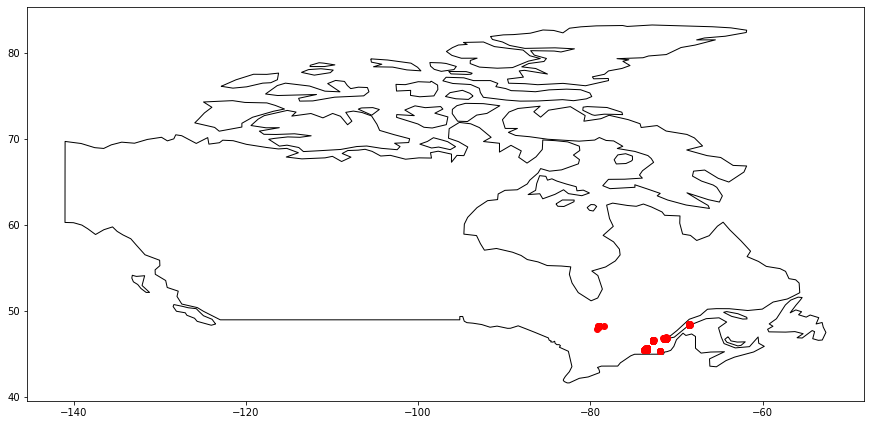

In [11]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15, 15))

# We restrict to South America.
world[world.name == 'Canada'].plot(ax = ax, color='white', edgecolor='black')


# We can now plot our ``GeoDataFrame``.
gdf_sales.plot(ax=ax, color='red')

plt.show()

## b. Displaying on an interactive map of quebec

This is done using the library folium in python

In [12]:
#Plot graph of sales in folium

sales_data_map = folium.map.FeatureGroup()
latitudes = list(gdf_sales.lat)
longitudes = list(gdf_sales.long)
sales = list(gdf_sales.sales)

In [13]:
#Build the map

DFW_Map = folium.Map(
                location = [45.537593, -73.597075], 
                zoom_start = 10)

In [14]:

# The size of the retail location varies with the number of sales
# Retail locations with red colors indicated sales with negative values

for lat, lng, sale in zip(latitudes, longitudes, sales):
  if sale <=0:
    folium.Circle(
        radius = 10*abs(sale),
      location = [lat, lng], 
      popup = sale,
      color='red', fill = False
     ).add_to(DFW_Map) 
  else:
    folium.Circle(
         radius = 10*abs(sale),
      location = [lat, lng], 
      popup = sale,
      color='green', fill = False
     ).add_to(DFW_Map)

In [15]:
DFW_Map.add_child(sales_data_map)
DFW_Map

In [30]:
#Get the location (City of retail location)
# initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")
retail_data['city'] = "null"

for index, row in retail_data.iterrows():
    location = geolocator.reverse(str(row['lat'])+","+str(row['long']))
    address = (location.raw['address'])
    city = address.get('city', '')
    retail_data['sales'].iloc[index] = city
    


C:\Users\ngani\anaconda3\envs\mlenv\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.089068703

In [31]:
retail_data

,erp_id,province_code,lat,long,sales,geometry,city
0,4,QC,45.537593,-73.597075,Montréal,POINT (-73.59708 45.53759),null
1,19,QC,45.488636,-73.568175,Montréal,POINT (-73.56817 45.48864),null
2,22,QC,48.387871,-68.470686,Rimouski,POINT (-68.47069 48.38787),null
3,24,QC,46.795660,-71.356166,,POINT (-71.35617 46.79566),null
4,37,QC,45.510311,-73.570841,Montréal,POINT (-73.57084 45.51031),null
...,...,...,...,...,...,...,...
1147,6821,QC,46.760381,-71.363740,Québec,POINT (-71.36374 46.76038),null
1148,6826,QC,46.817782,-71.253214,Québec,POINT (-71.25321 46.81778),null
1149,6830,QC,45.757450,-73.479966,,POINT (-73.47997 45.75745),null
1150,6849,QC,46.816699,-71.202551,Québec,POINT (-71.20255 46.81670),null


In [ ]:
'''m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data="data/Quebec.geojson",
    name="choropleth",
    data=data,
    columns=["sales"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Sales(%)"
).add_to(m)

folium.GeoJson(antarctic_ice_edge, name="geojson").add_to(m)
folium.LayerControl().add_to(m)

m'''